In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import sys
sys.path.append("../../")
from models.topics import TopicExtractionModel
from sentence_transformers import SentenceTransformer

In [2]:
headlines = pd.read_json("../../data/raw/headlines.json", lines=True)
headline_embeddings = pd.read_parquet("../../data/headline_embeddings.parquet")
headlines_merged = pd.merge(headlines, headline_embeddings, on="id", how="left")

In [3]:
from models.topics import NonStationaryFilter, HighKurtosisFilter, CompoundFilter
YEAR = 1977
sample_year = headlines_merged[headlines_merged["year"] == YEAR]

model = SentenceTransformer("all-MiniLM-L6-v2")
ns_filter = NonStationaryFilter(pvalue_threshold=0.1, n_periods=3)
kt_filter = HighKurtosisFilter(kurtosis_threshold=2)
compound_filter = CompoundFilter([ns_filter, kt_filter])
tm = TopicExtractionModel(model, topic_filter=compound_filter)
tm.fit(sample_year["headline"].tolist(), np.stack(sample_year["embedding"].tolist()), sample_year["month"].tolist())


In [4]:
tm.model.visualize_topics_over_time(tm.topics_over_time[tm.topics_over_time.Topic.isin(tm.topic_filter.topics)])

In [5]:
novels = pd.read_csv("../../data/nominated_novels.csv")
description_embeddings = pd.read_parquet("../../data/description_embeddings.parquet")
desc_merged = pd.get_dummies(novels[novels.year == YEAR], columns=['gender']).merge(description_embeddings, on="work_qid", how="left").groupby("work_qid").agg({
    'age': 'mean',
    'awards_as_of_year': 'sum',
    'embedding': 'first',
    'n_win': 'first',
    'n_nom': 'first',
    'gender_male': 'sum',
    'gender_female': 'sum',
}).dropna()

desc_merged.count()

age                  10
awards_as_of_year    10
embedding            10
n_win                10
n_nom                10
gender_male          10
gender_female        10
dtype: int64

In [6]:
from models.debias import NullspaceProjector, learn_nullspace_normal_vector

train_desc = pd.read_csv("../../data/train_desc_labeled.csv")
w = learn_nullspace_normal_vector(train_desc)
db = NullspaceProjector(normal_vector=w)
embeddings = db.transform(np.stack(desc_merged["embedding"].values))
db.fit(embeddings)
desc_aligned = desc_merged.assign(alignment=tm.compute_alignment(embeddings))
desc_aligned.head()

,age,awards_as_of_year,embedding,n_win,n_nom,gender_male,gender_female,alignment
work_qid,,,,,,,,
Q122452523,29.0,0,"[-0.026827814, 0.040379934, 0.03314715, 0.0314...",0,1,0,1,15.329641
Q1448428,54.0,11,"[-0.057265908, 0.11394991, 0.01380519, 0.04636...",0,1,1,0,15.331773
Q2377008,58.0,12,"[-0.025931792, 0.017050132, 0.024950795, -0.01...",1,2,1,0,15.321489
Q3135306,49.0,10,"[-0.012680732, -0.046038665, -0.0124388505, 0....",1,2,0,1,15.444714
Q3224982,38.0,1,"[-0.02369637, 0.10994188, -0.0010569477, 0.013...",0,1,1,0,15.322115


<Axes: xlabel='alignment', ylabel='Density'>

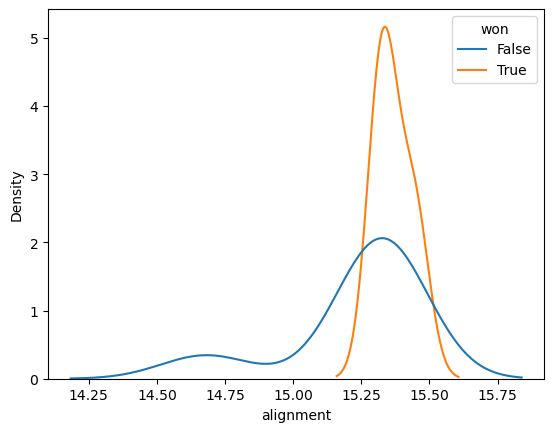

In [7]:
sns.kdeplot(x="alignment", data=desc_aligned.assign(won = desc_aligned.n_win > 0), hue='won', common_norm=False )

In [8]:
desc_aligned.reset_index().drop(columns=["work_qid", "embedding", "n_win"])

,age,awards_as_of_year,n_nom,gender_male,gender_female,alignment
0,29.0,0,1,0,1,15.329641
1,54.0,11,1,1,0,15.331773
2,58.0,12,2,1,0,15.321489
3,49.0,10,2,0,1,15.444714
4,38.0,1,1,1,0,15.322115
5,34.0,6,1,1,0,14.680282
6,42.0,46,2,1,0,15.316057
7,57.0,1,1,1,0,15.341320
8,55.0,0,0,1,0,15.336476
9,35.0,10,1,1,0,15.317621


In [9]:
from sklearn.feature_selection import mutual_info_regression
mutual_info_regression(desc_aligned[["alignment", "age", "awards_as_of_year"]], desc_aligned["n_win"])

array([0.03571429, 0.09095238, 0.01071429])

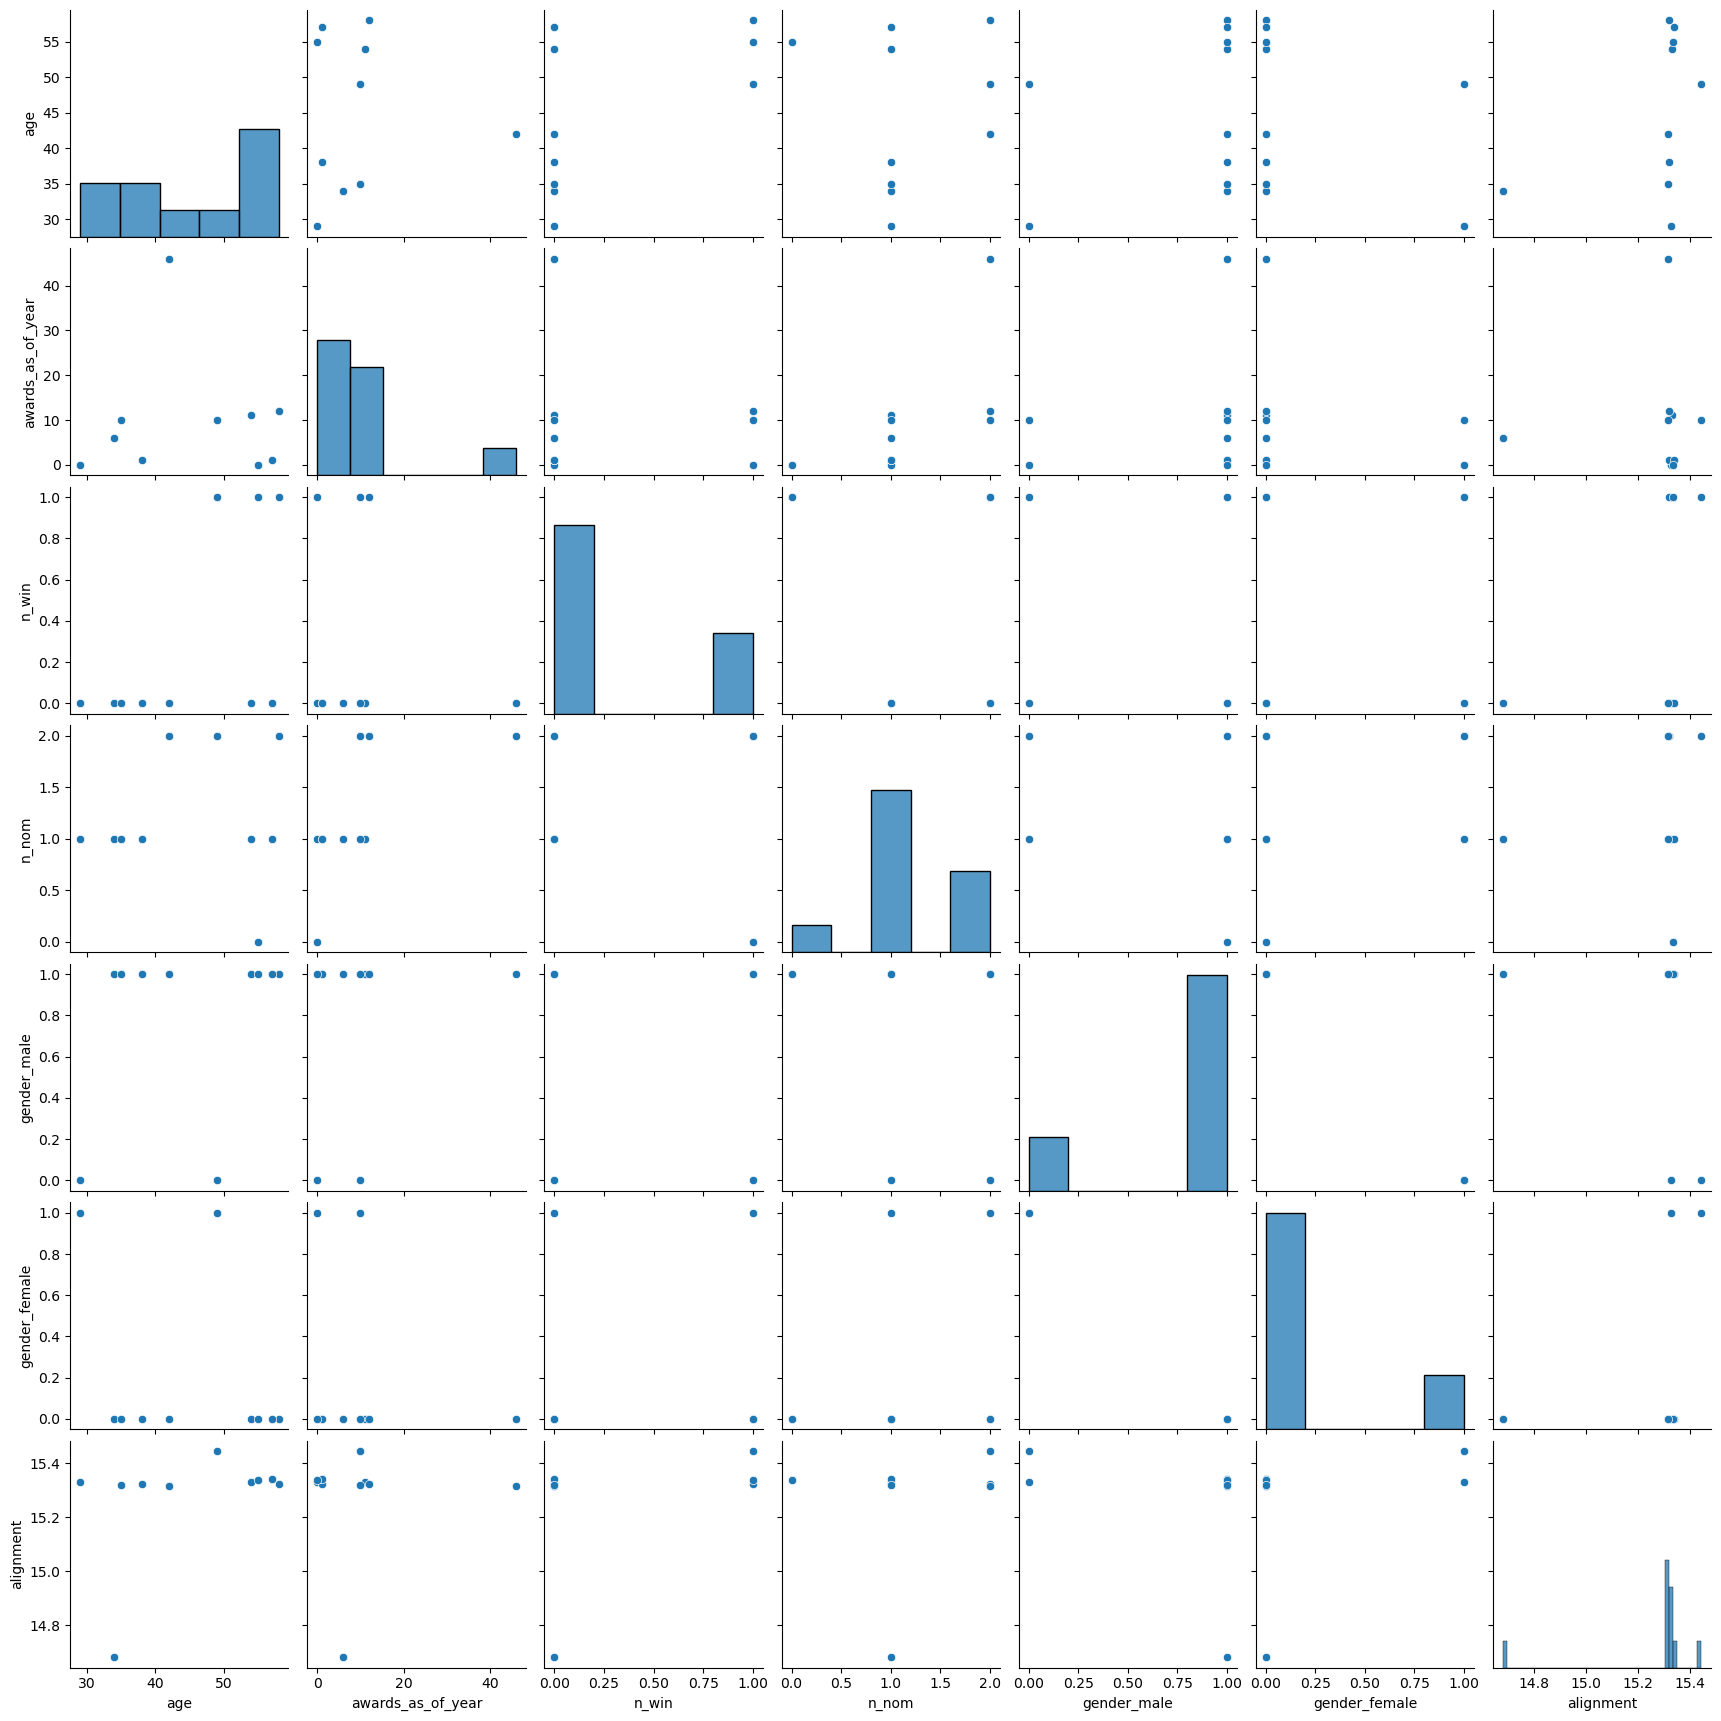

In [10]:
sns.pairplot(desc_aligned.reset_index().drop(columns=["work_qid", "embedding"]))